In [1]:
import numpy as np
import pandas as pd
import datetime 
from matplotlib import pyplot as plt 
import matplotlib
import math
from scipy import stats
from scipy.optimize import curve_fit
import seaborn as sns
from scipy import interpolate
import warnings
warnings.filterwarnings("ignore")

# NCE Computation

In [2]:
def data_merging(df,start_day,end_day, columns = 'user id',rows = 'issued time',value = 'organizer id'):
    days = (end_day - start_day).days + 1
    df[rows] = pd.to_datetime(df[rows])
    df=df.set_index(rows)
    df_merged = pd.DataFrame(index = pd.date_range(start_day,periods = days), columns = list(set(np.array(df[columns]))))
    df.index = df.index.map(lambda x: datetime.date(x.year,x.month,x.day)) #unify index
    df_merged.index = df_merged.index.map(lambda x: datetime.date(x.year,x.month,x.day)) #unify index
    new_df = pd.DataFrame(df_merged.reset_index().melt(id_vars='index').iloc[:,:2].values,columns=[rows,columns])
    new_df_filter = df.reset_index()
    merged = new_df.merge(new_df_filter.drop_duplicates(subset=[rows,columns]),on = [rows,columns],how = 'left') 
    merged['value'] = merged.loc[:,value].astype(str)
    return merged.pivot(index=rows,columns=columns,values=value).fillna(0)   


def participation_rate_NCE_computation(start_day,end_day,df,sliding_window_length = 14,Iteration_print = True):
    '''
    H(If Attends|User) = sum{P(U)*[P(Attend) * logP(Attend) + (1-P(Attend))* log(1-P(Attend))]}
    
    P(U): Probability to choose a single user in a specific sliding window
    P(Attend): Probabiliy for a specific user to join in a task
    '''
    days = (end_day - start_day).days + 1
    P_NCE = []
    y = 0
    for i in range(days-sliding_window_length+1):
        a = df[i:i+sliding_window_length] #Choose Sliding Window
        b = a.loc[:,~(a==0).all(axis=0)] #Filter Users who did not join any tasks in a specific sliding window
        M = b.apply(pd.value_counts).drop([0]).fillna(0)
        p = M.sum().div(sliding_window_length)#Users' participate rate matrix
        #Task number
        T_n = M.sum().sum()
        #Compute P(U)
        task_joined = M.sum(axis = 0)
        P_u = task_joined/T_n
        H_1 = -P_u*(p*np.log2(p)+(1-p)*np.log2(1-p)) #cross-entropy calculation step 1 
        H = H_1.fillna(0).sum() #Cross-entropy calculation step 2 NOTE: Having nan in results because of np.log(0 or near 0)
        H_if_attends = (-(p*np.log2(p)+(1-p)*np.log2(1-p))).fillna(0).sum()
        H_norm = H/H_if_attends
        P_NCE += [H_norm]
        if Iteration_print == True:
            y = y+1
            print('Iteration',y)
    return P_NCE


def organizer_preference_NCE_computation(start_day,end_day,df,sliding_window_length = 14, Iteration_print = True):
    """
    Compute issuer given user normalized conditional entropy
    
    Instructions:
    H(Issuer|User) = -sum(P(U)*sum(P(I|U)logP(I|U)))
    P(U) = #tasks a user joined in/#total tasks       
    Returns:
    O_NCE: Organizer preference NCE
    """
    days = (end_day -start_day).days+1
    O_NCE = []
    y = 0
    for i in range (days-sliding_window_length+1):
        a = df[i:i+sliding_window_length] #Choose sliding window
        b = a.loc[:,~(a==0).all(axis=0)] # Drop users that did not join in any tasks in the sliding window 
        M = b.apply(pd.value_counts).drop([0]).fillna(0) if 0 in b else b.apply(pd.value_counts).fillna(0)#Issuer and User Matrix  
        P_given = M.div(sliding_window_length) #P(Issuer|User) Matrix  
        T_n = M.sum().sum()#Task number
        task_joined = M.sum(axis = 0) #Compute P(U)
        P_u = task_joined/T_n
        H_i = (-P_given * np.log2(P_given)).fillna(0) #Conditional entropy calculation
        H_ece = (P_u * H_i).sum().sum()
        task_issued = M.sum(axis=1)
        P_i = task_issued/T_n
        Hissuer = (-P_i * np.log2(P_i)).sum()
        Huser = (-P_u * np.log2(P_u)).sum()
        #Normalized Entropy
        Hfrac = H_ece/Hissuer

        O_NCE += [Hfrac] 
        if Iteration_print == True:
            y = y+1
            print('Iteration',y)
    return O_NCE


def task_preference_NCE_computation(start_day,end_day,df,sliding_window_length = 14, Iteration_print = True):
    '''
    H(Task Type|Issuer) = -sum(p(Issuer)*sum(P(Task Type|Issuer)* log(Task Type|Issuer)))
    '''
    days = (end_day - start_day).days + 1
    T_NCE = []
    y = 0
    for i in range (days-sliding_window_length+1):
        sliding_window = df[i:i+sliding_window_length] #Sliding Window
        #drop task type "0" and compute P(task type|issuer) matrix
        M = sliding_window.loc[:,~(sliding_window==0).all(axis=0)].apply(pd.value_counts).drop([0]).fillna(0) 
        #P(task type|issuer)
        p = M.div(sliding_window_length)
        #issued task
        issued_task = M.sum(axis = 0)
        total_task = issued_task.sum()
        P_i =issued_task/total_task #P(Issuer)
        H_1 = -P_i * p * np.log2(p)#Conditional Entropy Calculation Step 1
        H = H_1.fillna(0).sum().sum()# Conditional Entropy Calculation Step2
        H_max = np.log2(M.shape[0])# Maximum Entropy
        normalized_entropy = H/H_max
        #H(task type)
        task_type_sum = M.sum(axis=1)
        P_task_type = task_type_sum/total_task
        Htasktype = (-P_task_type * np.log2(P_task_type)).sum()
        Hfrac = H/Htasktype
        T_NCE +=[Hfrac]
        if Iteration_print == True:
            y = y+1
            print('Iteration',y)
    return T_NCE

In [3]:
def shenzhen_nces():
    '''
    Compute participation rate, organizer and task preference NCEs for Shenzhen. 
    We have pre-computed all NCEs in Shenzhen and it's districts as shown in "Data/" file.
    '''
    df = pd.read_csv('Data/organizer_user_data.csv')
    df = df[~(df['issuer id'].isin([-1]))]
    d1 = datetime.datetime(2020,2,18)
    d2 = datetime.datetime(2021,1,18)
    res_shenzhen = data_merging(df,d1,d2)
    task = pd.read_csv('Data/organizer_task_data.csv')
    Shenzhen_p_nce = participation_rate_NCE_computation(d1,d2,res_shenzhen)
    Shenzhen_o_nce = organizer_preference_NCE_computation (d1,d2,res_shenzhen)
    Shenzhen_t_nce = task_preference_NCE_computation(d1,d2,data_merging(task,d1,d2,columns = 'organizer id',rows = 'issued time',value = 'task label'))

# Intervals Detection

In [4]:
def func(x1,alpha,beta,I):
    A = 1/(np.exp(-alpha*(np.log10(beta)-np.log10(alpha))/(beta-alpha))
           - np.exp(-beta*(np.log10(beta)-np.log10(alpha))/(beta-alpha)))
    y = A * I * (np.exp(-1 * alpha * x1)-np.exp(-1 * beta * x1))
    return y


def impulse_model_classification(NCE, start_time_step, end_time_step, fit_threshold=3,
                                 centralized_threshold=1e-2, plot_result=True):
    y = np.array(NCE)
    y1 = y[start_time_step:end_time_step]
    m = len(y1)
    x1 = np.array(range(m))
    res = None
    if max(y1) - min(y1) < ((max(y) - min(y)) / fit_threshold) or max(y1) - min(y1) == abs(y1[len(y1)-1] - y1[0]):
        alpha, beta, I = -1, -1, -1
    else:
        coef, _ = curve_fit(func, x1, y1 - min(y1),
                            p0=[1 / (m / 5), 1 / (m / 3), max(y1) - min(y1)], maxfev=10000)
        alpha, beta, I = coef[0], coef[1], coef[2]

    if alpha < 0 or beta < 0:
        res = 0
    elif (1 / alpha) > m > (1 / beta):
        res = 1  # low organization ability
    elif m > (1 / alpha) > (1 / beta) and centralized_threshold < (1 / alpha) - (1 / beta):
        res = 2  # self-organized
    elif centralized_threshold > (1 / alpha) - (1 / beta) and m > (1 / alpha) > (1 / beta):
        res = 3  # extremely high organized ability(centralized)
    else:
        res = 0  # Invalid

    if plot_result:
        plt.plot(x1, y1 - min(y1), 'red', label='True NCE')
        plt.plot(x1, func(x1, alpha, beta, I), 'blue', label='Fitted NCE')
        plt.legend()
        plt.xlabel('Sliding Window')
        plt.ylabel('NCE - min(NCE)')
        plt.title('Comparison Between True and Fitted NCE')
    return res, alpha, beta, I

def start_time_duration_matrix(NCE,maximum_duration = 60, minimum_duration = 5, f_threshold=3, c_threshold = 1e-2,
                               date_res = True, descending = False):
    m = len(NCE)
    matrix = np.zeros((maximum_duration-minimum_duration, m-maximum_duration))
    for i in range(0, maximum_duration-minimum_duration):
        for j in range(0, m-maximum_duration):
            matrix[i, j] = impulse_model_classification(NCE, j, j+i+minimum_duration, fit_threshold=f_threshold,
                                                        centralized_threshold= c_threshold, plot_result=False)[0]
    df = pd.DataFrame(matrix)
    df.index = range(minimum_duration, maximum_duration)
    if date_res:
        df.columns = pd.date_range('20200218', periods=m - maximum_duration, freq='1D')\
            .map(lambda x: datetime.date(x.year, x.month, x.day))
    if descending:
        df = df.sort_index(ascending = False)
    return df

def if_overlap(a_start, a_end, b_start, b_end):
    if max(a_start, b_start) <= min(a_end, b_end):
        return True
    else:
        return False

def maximal_self_organization_intervals_search(df, minimum_duration=5):
    m, n = df.shape
    M = np.array(df)
    res = []
    for ind in range(m-1):
        row = m-1-ind
        duration = row + minimum_duration
        a = np.where(M[row, ])[0]
        if len(a) != 0:
            res.append((max(a), max(a)+duration))
            for i in range(m):
                for j in range(n):
                    if if_overlap(j, j+i+minimum_duration, max(a), max(a)+duration):
                            M[i, j] = 0
    res.sort()
    return res


def organization_speed_computation(NCE,intervals):
    organizational_speed = []
    for i in range(len(intervals)):
        y = impulse_model_classification(NCE,intervals[i][0],intervals[i][1],plot_result=False)
        alpha = y[1]
        beta = y[2]
        interval_length = intervals[i][1] - intervals[i][0] + 1
        T_peak = (np.log10(beta)-np.log10(alpha))/(beta-alpha)
        if T_peak is np.nan:
            organizational_speed.append(0)
        else:
            organizational_speed.append((1/alpha - T_peak)/(interval_length - T_peak))
    return organizational_speed

def interval_plot(NCE, res_interval,ratio,color_edge = 'blue',color_map = plt.cm.Blues, start_time = datetime.datetime(2020, 2, 18)):
    #RdYlBu_r
    y = np.array(NCE)
    d1 = start_time
    x = pd.date_range(d1, periods=len(y))
    #RdYlBu_r
    cmap=color_map
    for i in range(len(res_interval)):
        start = res_interval[i][0]
        end = res_interval[i][1]
        color = cmap(ratio[i])
        rect = plt.Rectangle((x[start], min(y[start:end])), x[end] - x[start], max(y[start:end])-min(y[start:end]), 
                             fill=True, edgecolor=color_edge,facecolor= color,linewidth=1.5)
        plt.gca().add_patch(rect)

In [5]:
def nce_plot_with_organizational_speed(NCE, threshold = 3):
    '''
    Generate the NCE plot with color shaded self-organizational intervals. 
    '''
    res_matrix = start_time_duration_matrix(NCE, maximum_duration=90, minimum_duration=5,
                                                    f_threshold=threshold, c_threshold=1e-2, date_res=False, descending=False)
    res_intervals = maximal_self_organization_intervals_search(res_matrix.replace(1, 0))
    res_speed = organization_speed_computation(NCE, res_intervals)
    d1 = datetime.datetime(2020,2,18)
    d2 = datetime.datetime(2021,1,18)
    dates = pd.date_range(d1,periods = (d2-d1).days + 1 -13)
    plt.plot(dates,NCE)
    plt.xticks(rotation = '60')
    plt.ylabel('NCE',fontsize=16)
    interval_plot(NCE,res_intervals,res_speed)

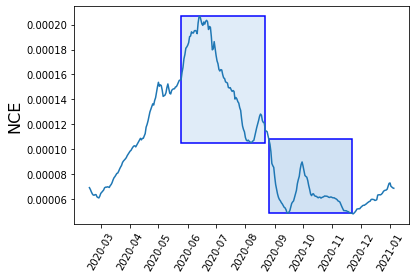

In [6]:
nce_plot_with_organizational_speed(pd.read_csv('Data/P_NCE.csv')['shenzhen'], threshold = 3)

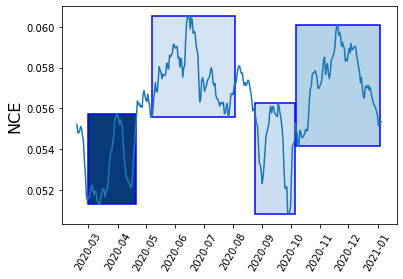

In [7]:
nce_plot_with_organizational_speed(pd.read_csv('Data/O_NCE.csv')['shenzhen'], threshold = 2.5)

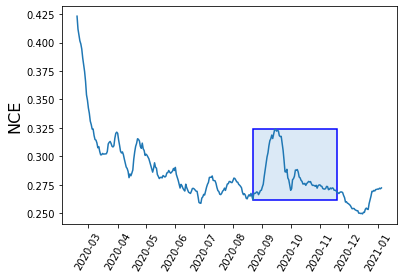

In [8]:
nce_plot_with_organizational_speed(pd.read_csv('Data/T_NCE.csv')['shenzhen'], threshold = 3)

# Case Study

In [9]:
def nces_for_neighborhood(df):
    subdf1 = df[df['task label']==4].copy(deep=True) #educational tasks
    subdf2 = df[df['task label']==5].copy(deep=True) #environmental tasks
    subdf3 = df[df['task label']==6].copy(deep=True) #covid tasks
    d1 = datetime.datetime(2020,8,1)
    d2 = datetime.datetime(2021,1,18)
    d3 = datetime.datetime(2020,2,18)
    res_sub1 = data_merging(subdf1,d1,d2)
    res_sub2 = data_merging(subdf2,d1,d2)
    res_sub3 = data_merging(subdf3,d3,d2)
    o_nce_edu = organizer_preference_NCE_computation (d1,d2,res_sub1)
    o_nce_envir = organizer_preference_NCE_computation (d1,d2,res_sub2)
    o_nce_covid = organizer_preference_NCE_computation (d3,d2,res_sub3)
    return o_nce_edu,o_nce_envir,o_nce_covid
def padding_nce(NCE):
    no_pad_x = [i for i in range(len(NCE)) if np.isnan(NCE[i]) == False]
    no_pad_NCE = [NCE[i] for i in range(len(NCE)) if np.isnan(NCE[i]) == False]
    x = [i for i in range(len(NCE))]
    f = interpolate.interp1d(no_pad_x, no_pad_NCE,fill_value="extrapolate")
    NCE_padded = f(x)
    return NCE_padded
def case_study_1_plot(NCE,d = 30):
    mmin, mmax = 0.95 * min(list(NCE[:d])+list(NCE[-d:])),1.05 * max(list(NCE[:d])+list(NCE[-d:]))
    fig = plt.figure(figsize=(12, 8))
    plt.subplot(121)
    d1 = datetime.datetime(2020,2,18)
    dates = pd.date_range(d1,periods = len(NCE))
    plt.plot(dates[:d],NCE[:d],'b',label = 'Early Stage of Pandemic')
    plt.ylim(mmin, mmax)
    plt.xticks(rotation = '60')
    plt.legend(loc='upper right',fontsize=12)
    plt.subplot(122)
    plt.plot(dates[-d-13:-13],NCE[-d:],'r',label = 'Late Stage of Pandemic')
    plt.ylim(mmin, mmax)
    plt.xticks(rotation = '60')
    plt.legend(loc='upper right',fontsize=12)
def case_study_2_plot(envir_new,edu_new):
    res_envir = start_time_duration_matrix(envir_new, maximum_duration=90, minimum_duration=5,
                                                    f_threshold=2.5, c_threshold=1e-2, date_res=False, descending=False)
    res_edu = start_time_duration_matrix(edu_new, maximum_duration=90, minimum_duration=5,
                                                    f_threshold=2.5, c_threshold=1e-2, date_res=False, descending=False)
    interval_envir =  maximal_self_organization_intervals_search(res_envir.replace(1, 0))
    interval_edu =  maximal_self_organization_intervals_search(res_edu.replace(1, 0))
    speed_envir = organization_speed_computation(envir_new, interval_envir)
    speed_edu = organization_speed_computation(edu_new,interval_edu)
    d1 = datetime.datetime(2020,8,1)
    dates = pd.date_range(d1,periods = len(envir_new))
    plt.plot(dates,envir_new,'b',label = 'Environmental')
    interval_plot(envir_new,interval_envir,speed_envir,start_time=datetime.datetime(2020, 8, 1))
    plt.plot(dates,edu_new,'r',label = 'Educational')
    interval_plot(edu_new,interval_edu,speed_edu,color_edge='red',color_map = plt.cm.Reds,start_time=datetime.datetime(2020, 8, 1))
    plt.xticks(rotation = '60')
    plt.ylabel('NCE',fontsize=16)
    plt.legend(loc = 'upper right')
    #plt.savefig('neighbor_15.pdf',dpi=500, bbox_inches='tight')
    print('The averge convergence speed for educational tasks is: %s, that for environmental tasks is: %s'%(np.mean(speed_edu),np.mean(speed_envir)))
    print('Does the convergence speed for educational tasks higher than that of environmental tasks?',np.mean(speed_edu)>np.mean(speed_envir))

In [10]:
neighbor_1 = pd.read_csv('Data/neighborhood_1.csv')
neighbor_2 = pd.read_csv('Data/neighborhood_2.csv')
edu_1,envir_1,covid_1 = nces_for_neighborhood(neighbor_1)
edu_2,envir_2,covid_2 = nces_for_neighborhood(neighbor_2)

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration 77
Iteratio

Iteration 294
Iteration 295
Iteration 296
Iteration 297
Iteration 298
Iteration 299
Iteration 300
Iteration 301
Iteration 302
Iteration 303
Iteration 304
Iteration 305
Iteration 306
Iteration 307
Iteration 308
Iteration 309
Iteration 310
Iteration 311
Iteration 312
Iteration 313
Iteration 314
Iteration 315
Iteration 316
Iteration 317
Iteration 318
Iteration 319
Iteration 320
Iteration 321
Iteration 322
Iteration 323
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iter

Iteration 264
Iteration 265
Iteration 266
Iteration 267
Iteration 268
Iteration 269
Iteration 270
Iteration 271
Iteration 272
Iteration 273
Iteration 274
Iteration 275
Iteration 276
Iteration 277
Iteration 278
Iteration 279
Iteration 280
Iteration 281
Iteration 282
Iteration 283
Iteration 284
Iteration 285
Iteration 286
Iteration 287
Iteration 288
Iteration 289
Iteration 290
Iteration 291
Iteration 292
Iteration 293
Iteration 294
Iteration 295
Iteration 296
Iteration 297
Iteration 298
Iteration 299
Iteration 300
Iteration 301
Iteration 302
Iteration 303
Iteration 304
Iteration 305
Iteration 306
Iteration 307
Iteration 308
Iteration 309
Iteration 310
Iteration 311
Iteration 312
Iteration 313
Iteration 314
Iteration 315
Iteration 316
Iteration 317
Iteration 318
Iteration 319
Iteration 320
Iteration 321
Iteration 322
Iteration 323


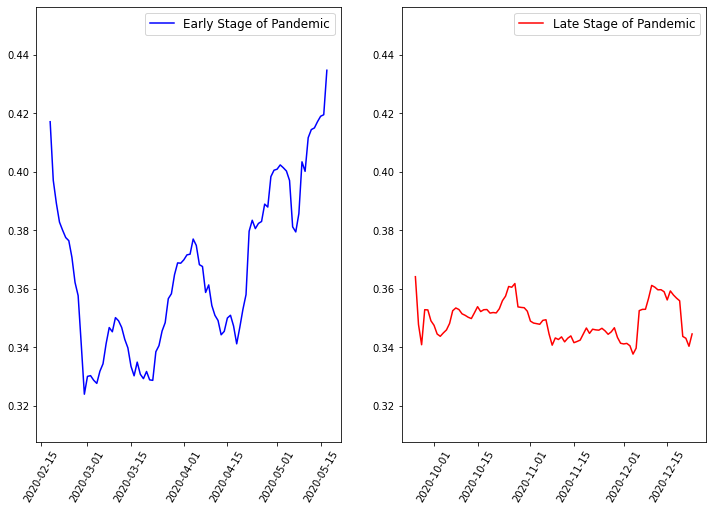

In [16]:
case_study_1_plot(padding_nce(covid_1),d=90)

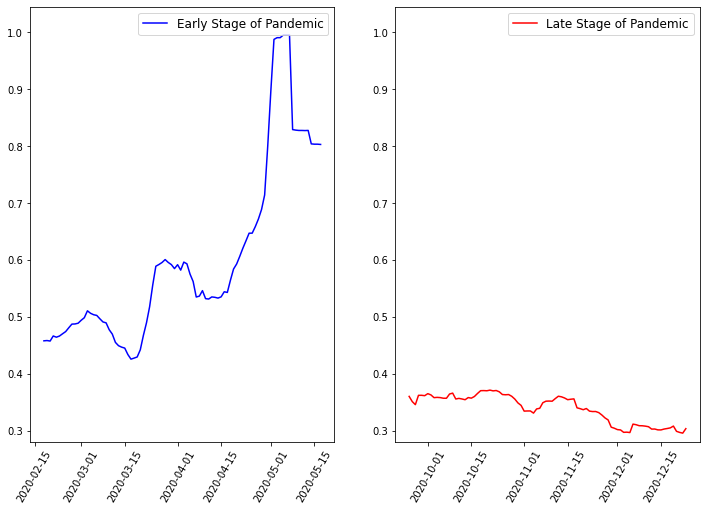

In [17]:
case_study_1_plot(padding_nce(covid_2),d=90)

The averge convergence speed for educational tasks is: 0.5609961090802199, that for environmental tasks is: 0.16411826090915843
Does the convergence speed for educational tasks higher than that of environmental tasks? True


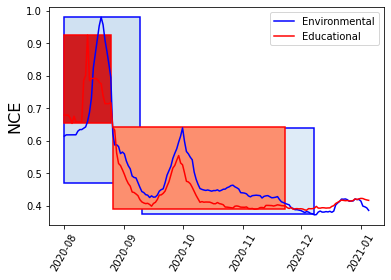

In [18]:
case_study_2_plot(padding_nce(envir_1),padding_nce(edu_1))

The averge convergence speed for educational tasks is: 0.15592311745377305, that for environmental tasks is: 0.07428433293568708
Does the convergence speed for educational tasks higher than that of environmental tasks? True


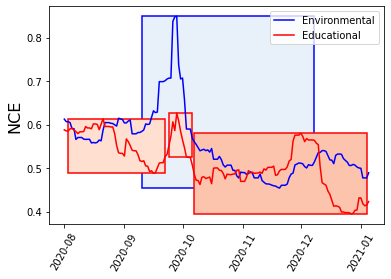

In [19]:
case_study_2_plot(padding_nce(envir_2),padding_nce(edu_2))